In [174]:
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
import pandas as pd

from tqdm import tqdm

In [175]:
data = pd.read_pickle('data.pkl')

In [176]:
print('ratio of trains that show defects: ',end='')
print(sum(data['target_vector'].apply(np.sum) > 0), 'of', len(data))

ratio of trains that show defects: 24 of 35


overall duration of target sound in seconds 80.6


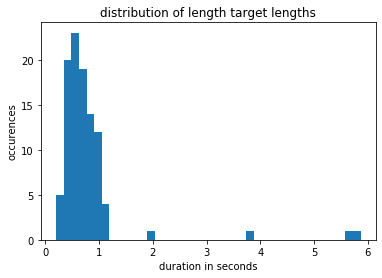

In [177]:
defect_duration_lists = data['durations_in_s'].tolist()
defect_durations = [val for sublist in defect_duration_lists for val in sublist]
defect_durations = [dur for dur in defect_durations if dur != 0.0]
print(f'overall duration of target sound in seconds {sum(defect_durations):.1f}')

counts, bins, _ = plt.hist(defect_durations, 40)
plt.title('distribution of length target lengths');
plt.xlabel('duration in seconds'); plt.ylabel('occurences');

In [178]:
frame_len = 8000

In [179]:
# overall length
total_len = np.hstack(data['audio_content'].tolist()).shape[0]
print(f'overall duration of dataset in minutes {total_len/8000/60:.2f}')
print(f'ratio of anomalous to normal audio {sum(defect_durations)/(total_len/8000):.2%}')

overall duration of dataset in minutes 23.37
ratio of anomalous to normal audio 5.75%


# Listen to Slices

In [180]:
frame_length = 8000

# extract slices
X = data['audio_content'].apply(librosa.util.frame, 
                                frame_length=frame_length, 
                                hop_length=frame_length)
X = X.apply(np.transpose)
y = data['target_vector'].apply(librosa.util.frame, 
                                frame_length=frame_length,
                                hop_length=frame_length)
y = y.apply(np.transpose)

# collect in data frame
sliced = pd.DataFrame()
sliced['X'] = X.explode()
sliced['y'] = y.explode()

sliced.index.rename('file_number', inplace=True)
sliced.reset_index(inplace=True)

In [181]:
# slices with non zero target
print('anomalous slices:',
      len(sliced['y'][sliced['y'].apply(np.sum) > 1600]),
      '\nof total slices:',
      len(sliced['y']))

anomalous slices: 136 
of total slices: 1386


In [182]:
def sum_threshold(x, threshold=1600):
    x = np.sum(x) > threshold
    return float(x)
    
sliced['y'] = sliced['y'].apply(sum_threshold)

In [183]:
anomalous_sample_idx = sliced.index[sliced['y']!=0].tolist()

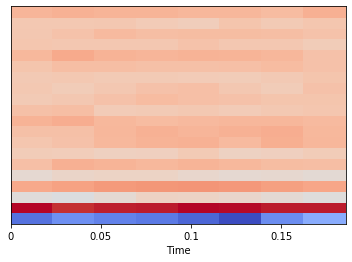

In [189]:
samp = sliced['X'][anomalous_sample_idx[45]]
sampfcc = librosa.feature.mfcc(y=samp, sr=8000, hop_length=1024, htk=True)
librosa.display.specshow(sampfcc, x_axis='time')
import IPython.display as ipd
ipd.Audio(samp, rate=8000)